# All Ireland Mbovis strain diversity

Run all samples together

In [1]:
import sys,os,shutil,subprocess
import glob
from importlib import reload
import numpy as np
import pandas as pd
pd.set_option('display.width', 200)
import pylab as plt
import matplotlib as mpl
from Bio import SeqIO
sys.path.append('pathogenie')
from snipgenie import tools, aligners, app, trees, plotting

## run NI first

In [ ]:
reload(app)
args = {'threads':20, 'outdir': '/storage/btbgenie/NI_results', 'labelsep':'_',
        'input':['/storage/btbgenie/mbovis_ireland/NI'],
         'reference': None, 'overwrite':False,
         'custom_filters': True,
         'mask': app.mbovis_mask,
         'buildtree':True}
W = app.WorkFlow(**args)
st = W.setup()
W.run()

## custom code to integrate previously aligned bam files together and call variants

This allows us to join previously mapped results together in one call without re-aligning

In [ ]:
#read in bam files
mapped = {'wicklow':'/storage/btbgenie/wicklow_results/mapped/',
                'monaghan':'/storage/btbgenie/monaghan/monaghan_results/mapped/',
                'NI':'/storage/btbgenie/NI_results/','UK':'/storage/btbgenie/UK_results/mapped'}
reload(app)
bam_files=[]
for m in mapped:
    f=app.get_files_from_paths(mapped[m], '*.bam')
    bam_files.extend(f)
print (len(bam_files))

outdir='/storage/btbgenie/all_ireland_results'
df = app.get_samples(bam_files,sep='_')
app.write_samples(df, outdir)

In [ ]:
#df.to_csv('/storage/btbgenie/mbovis_ireland/temp.csv',index=False)

## run rest of workflow as usual

In [8]:
gff_file=os.path.join(outdir,'mbovis.gff')
tools.gff_bcftools_format(app.mbovis_gb, gff_file)
vcf_file = app.variant_calling(bam_files, app.mbovis_genome, outdir, threads=20,                               
                                mask=app.mbovis_mask, gff_file=gff_file,
                                custom_filters=True, overwrite=False)
snprecs, smat = tools.fasta_alignment_from_vcf(vcf_file, omit=['161-MBovis'])
outfasta = os.path.join(outdir, 'core.fa')
SeqIO.write(snprecs, outfasta, 'fasta')
smat.to_csv(os.path.join(outdir,'core.txt'), sep=' ')

/storage/btbgenie/all_ireland_results/raw.bcf already exists
calling snps..
bcftools call -V indels --ploidy 1 -m -v -o /storage/btbgenie/all_ireland_results/calls.vcf /storage/btbgenie/all_ireland_results/raw.bcf
bcftools reheader --samples /storage/btbgenie/all_ireland_results/samples.txt -o /tmp/calls.vcf /storage/btbgenie/all_ireland_results/calls.vcf
bcftools filter -i "QUAL>=40 && FORMAT/DP>=30 && DP4>=4 && MQ>30" -o /storage/btbgenie/all_ireland_results/filtered.vcf.gz -O z /storage/btbgenie/all_ireland_results/calls.vcf
using mask bed file /home/farrell/gitprojects/snpgenie/snpgenie/data/Mbovis_AF212297_mask.bed
found 298 sites in masked regions
proximity filter found 2075/2401 sites
bcftools csq -f /home/farrell/.config/snpgenie/genome/Mbovis_AF212297.fa -g /storage/btbgenie/all_ireland_results/mbovis.gff /storage/btbgenie/all_ireland_results/filtered.vcf.gz -Ot -o /storage/btbgenie/all_ireland_results/csq.tsv
took 194.0 seconds
found 1983 sites
38 sites with at least one miss

In [16]:
treefile = trees.run_RAXML(outfasta, bootstraps=100, outpath=outdir, threads=12)

raxmlHPC-PTHREADS -f a -N 100 -T 12 -m GTRCAT -V -p 28698902 -x 25313430 -n variants -w /storage/btbgenie/all_ireland_results -s /storage/btbgenie/all_ireland_results/core.fa


In [3]:
meta = pd.read_csv('/storage/btbgenie/mbovis_ireland/all_ireland_samples.csv')
print (len(meta))

249


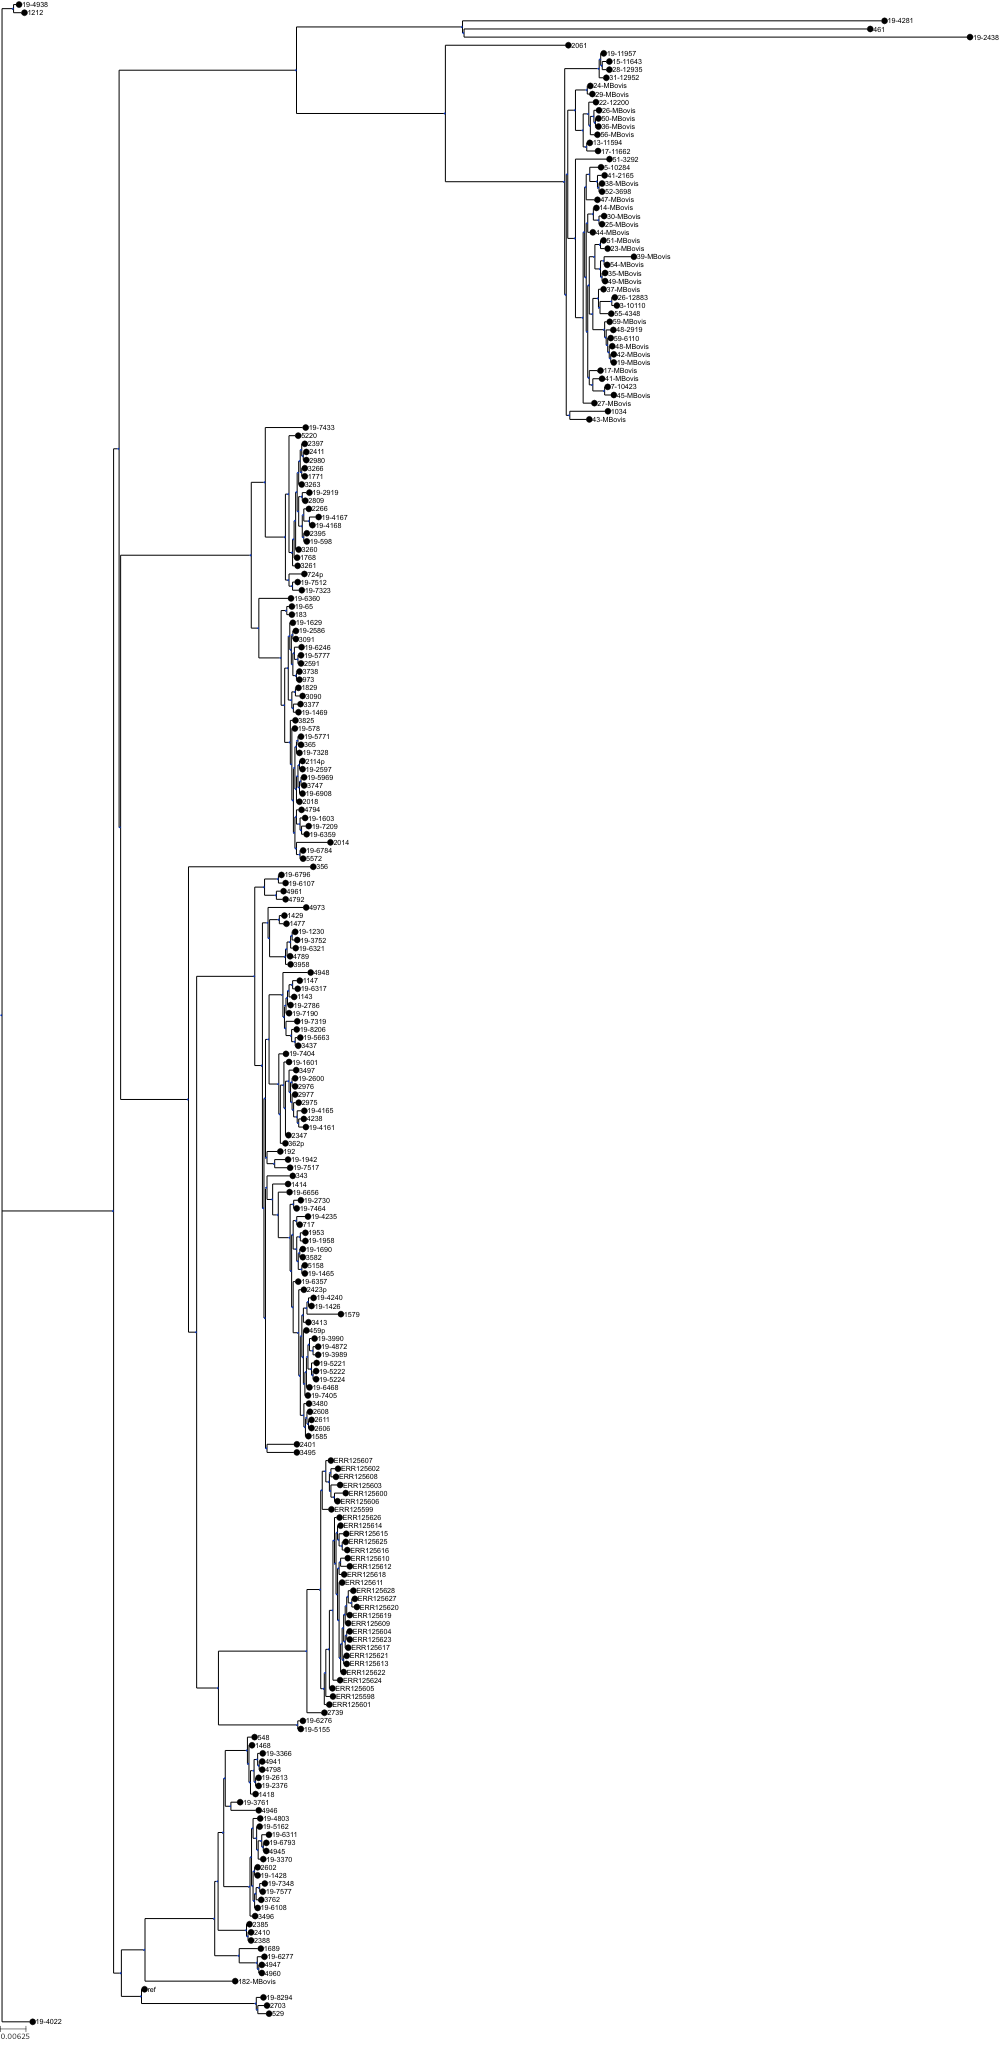

In [13]:
reload(trees)
from ete3 import CircleFace, TreeStyle, NodeStyle, RectFace, TextFace
treefile = '/storage/btbgenie/all_ireland_results/RAxML_bipartitions.variants'

def make_tree():
    
    labelmap = dict(zip(meta['name'],meta.species))
    colormap = trees.colors_from_labels(meta,'name','county')
    t,ts = trees.create_tree(treefile, 'ref', colormap=colormap)  #labelmap=labelmap
    colors = {'wicklow': 'blue', 'monaghan': 'green','NI':'crimson'}
    for i in colors:
        f=ts.legend.add_face(
                TextFace(text=i,fgcolor=colors[i],fsize=28),            
                column=0)
    return t

t = make_tree()
ts=TreeStyle()
ts.scale=8000
t.render("%%inline",tree_style=ts,w=1000)

In [10]:
t = make_tree()
#out = t.get_common_ancestor("19-4281", "19-2438", "461")
#out.delete()

In [15]:
def color_clades(t):
    wick = t.get_common_ancestor("19-11957", "43-MBovis")
    mon = t.get_common_ancestor("19-7433", "19-6796")
    mon2 = t.get_common_ancestor("548", "2703")
    ni = t.get_common_ancestor("ERR125607","ERR125601")

    colors=['LightSteelBlue','lightgreen','lightgreen','salmon']
    for common,clr in zip([wick,mon,mon2,ni],colors):
        nodesinbranch = [node for node in common.traverse()]
        nstyle1=NodeStyle()
        nstyle1['bgcolor']=clr
        common.set_style(nstyle1)
        
color_clades(t)

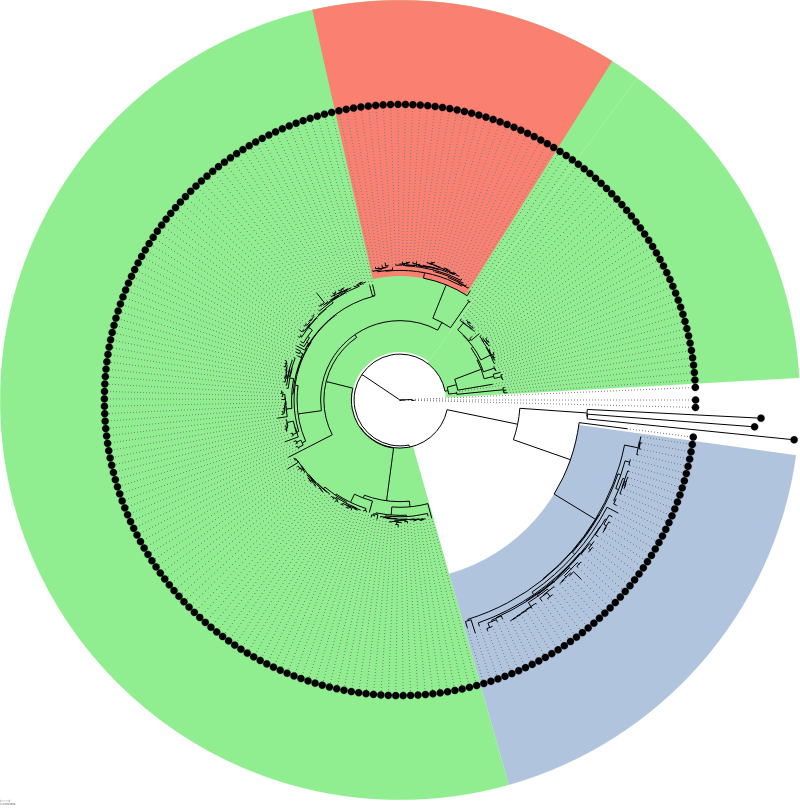

In [20]:
reload(trees)
ts=TreeStyle()
ts.scale=9000
ts.show_leaf_name = False
trees.set_nodesize(t, 40)
ts.mode = 'c'
t.render("%%inline",tree_style=ts,w=800)
#t.render("/storage/btbgenie/all_ireland.png",tree_style=ts,w=2000)

## spoligotypes of all samples

In [102]:
paths = {'Wicklow':'/storage/btbgenie/mbovis_ireland/Wicklow','Monaghan':'/storage/btbgenie/mbovis_ireland/Monaghan/',
         'NI':'/storage/btbgenie/mbovis_ireland/NI/'}
samples = []
for p in paths:
    f = app.get_files_from_paths(paths[p])   
    df = app.get_samples(f,sep='_')
    print (len(df['sample'].unique()))
    df=df.drop_duplicates('sample')   
    df['county'] = p   
    samples.append(df)

samples = pd.concat(samples)
#samples = samples.drop_duplicates(subset=['sample','county'])

47
171
31


In [80]:
samples.county.value_counts()

Monaghan    171
Wicklow      47
NI           31
Name: county, dtype: int64

In [ ]:
reload(tools)
res=[]
for i,r in samples.iterrows():    
    f=r.filename
    b = tools.get_spoligotype(f,1e6)
    sb = tools.get_sb_number(b)
    print (f, sb, b)
    res.append([f,sb,b])
    
res = pd.DataFrame(res,columns=['filename','SB','code'])

In [187]:
x = samples.merge(res,on='filename')
#x.to_csv('/storage/btbgenie/spoligotypes.csv',index=False)

In [24]:
x = pd.read_csv('/storage/btbgenie/spoligotypes.csv')
colormap = trees.colors_from_labels(x,'sample','SB')
labelmap = dict(zip(x['sample'],x.SB))
t,ts = trees.create_tree(treefile, 'ref')#, colormap=colormap, labelmap=labelmap)
color_clades(t)
trees.color_leaves(t, colormap)
trees.set_tiplabels(t,labelmap)
colors = {'wicklow': 'blue', 'monaghan': 'green','NI':'crimson'}
for i in colors:
       f=ts.legend.add_face(
             TextFace(text=i,fgcolor=colors[i],fsize=28),            
              column=0)

In [ ]:
ts.mode = 'c'
trees.set_nodesize(t, 10)
ts.scale=2000
t.render("%%inline",tree_style=ts,w=800)
#t.render("/storage/btbgenie/sb_tree.png",tree_style=ts,w=2000)

## SNP analysis

* snps unique to each clade/county
* protein groups containing common snps

In [11]:
c = app.read_csq_file('/storage/btbgenie/all_ireland_results/csq.tsv')
c[:10]

,1,sample,2,chrom,start,snp_type,gene,locus_tag,strand,feature_type,aa,nuc
0,CSQ,31-12952,1,LT708304.1,1057,missense,dnaA,BQ2027_MB0001,protein_coding,+,353I>353V,1057A>G
1,CSQ,48-MBovis,1,LT708304.1,1057,missense,dnaA,BQ2027_MB0001,protein_coding,+,353I>353V,1057A>G
2,CSQ,49-MBovis,1,LT708304.1,1057,missense,dnaA,BQ2027_MB0001,protein_coding,+,353I>353V,1057A>G
3,CSQ,28-12935,1,LT708304.1,1057,missense,dnaA,BQ2027_MB0001,protein_coding,+,353I>353V,1057A>G
4,CSQ,27-MBovis,1,LT708304.1,1057,missense,dnaA,BQ2027_MB0001,protein_coding,+,353I>353V,1057A>G
5,CSQ,15-11643,1,LT708304.1,1057,missense,dnaA,BQ2027_MB0001,protein_coding,+,353I>353V,1057A>G
6,CSQ,59-MBovis,1,LT708304.1,1057,missense,dnaA,BQ2027_MB0001,protein_coding,+,353I>353V,1057A>G
7,CSQ,182-MBovis,1,LT708304.1,1057,missense,dnaA,BQ2027_MB0001,protein_coding,+,353I>353V,1057A>G
8,CSQ,59-6110,1,LT708304.1,1057,missense,dnaA,BQ2027_MB0001,protein_coding,+,353I>353V,1057A>G
9,CSQ,41-2165,1,LT708304.1,1057,missense,dnaA,BQ2027_MB0001,protein_coding,+,353I>353V,1057A>G


<AxesSubplot:>

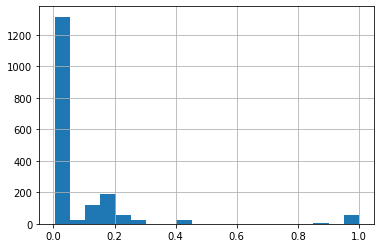

In [44]:
snp_mat = app.get_aa_snp_matrix(c)
labelmap = dict(zip(meta['name'],meta.county))
snp_mat = snp_mat.rename(columns=labelmap)
freqs = snp_mat.sum(1)/len(snp_mat.columns)
freqs =freqs.rename('freq') 
freqs.sort_values()
freqs.hist(bins=20)


In [47]:
x=freqs[freqs>0.1].reset_index()
x.to_csv('/storage/btbgenie/ireland_snps.csv')

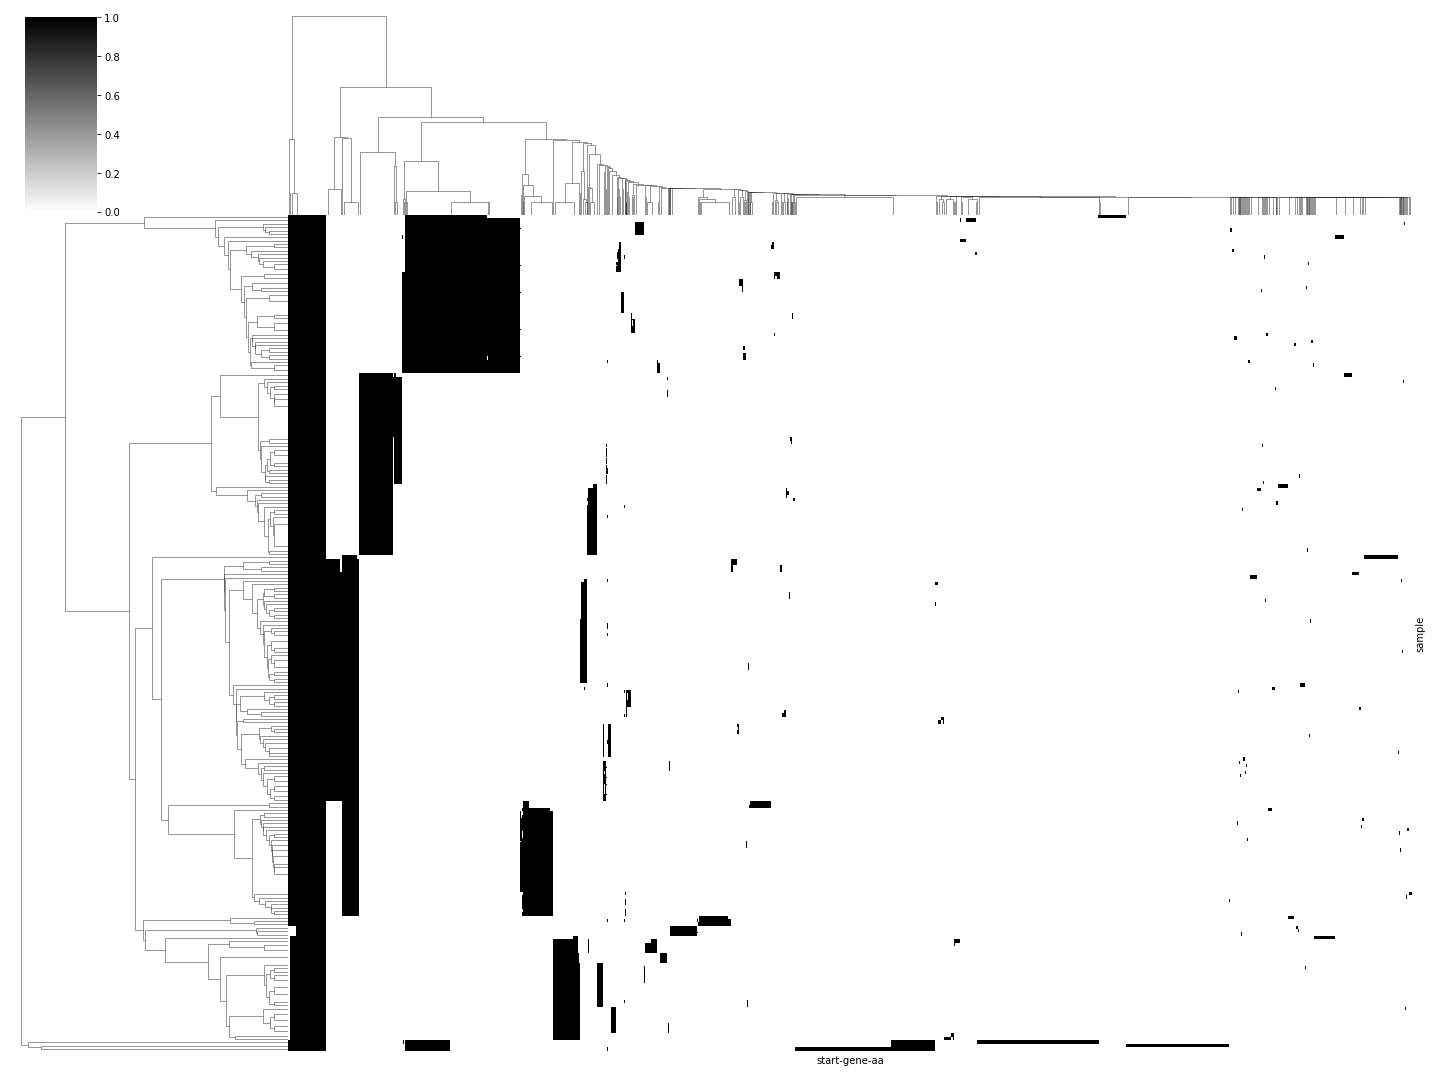

In [23]:
import seaborn as sns
sns.clustermap(snp_mat.T,figsize=(20,15),xticklabels=False,yticklabels=False,cmap='gray_r')